In [9]:
import paho.mqtt.client as paho
import numpy as np
import random
import json
import networkx as nx
from node import EpidemicGraph, TransitionDiagram, calc_R0
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
# %matplotlib inline

In [10]:
broker_ip = '192.168.0.104'
broker_ip = 'localhost'
broker_ip = '10.1.199.251'
broker_ip = '10.101.6.111'
connflag = False

In [16]:
def plot(G, title='step_1', ns=1000, fs=12, lim=2):
    pos = nx.get_node_attributes(G, 'position')
    ids = {i:i for i in range(N)}


    s_a = [x for x,y in G.nodes(data=True) if y['state']=='S_a']
    s_s = [x for x,y in G.nodes(data=True) if y['state']=='S_s']
    i1_a = [x for x,y in G.nodes(data=True) if y['state']=='I1_a']
    i1_s = [x for x,y in G.nodes(data=True) if y['state']=='I1_s']
    i2_a = [x for x,y in G.nodes(data=True) if y['state']=='I2_a']
    i2_s = [x for x,y in G.nodes(data=True) if y['state']=='I2_s']


    fig = plt.figure(figsize=(5, 5))
    nx.draw_networkx_edges(G, pos, alpha=0.8)
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_a, node_color='#66ff99')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_s, node_color='#006600')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_a, node_color='#ff6666')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_s, node_color='#cc0000')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_a, node_color='#3399ff')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_s, node_color='#0000cc')
    nx.draw_networkx_labels(G, pos, ids, font_size=fs)

    plt.title(title)
    red_patch = mpatches.Patch(color='red', label='I1')
    blue_patch = mpatches.Patch(color='blue', label='I2')
    green_patch = mpatches.Patch(color='green', label='S')
    plt.legend(handles=[green_patch, red_patch, blue_patch])
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    return plt, fig

In [12]:
mqttc = paho.Client()
counter = 0
N = 41
def on_connect(client, userdata, flags, rc):
    global connflag
    #if connection is successful, rc value will be 0
    print("Connection returned result: " + str(rc) )
    connflag = True

def on_message(client, userdata, msg): 
    print("-t {} | -p {}".format(msg.topic, msg.payload.decode()) )
    
def on_state(client, userdata, msg): 
    global G, counter
    counter += 1
    format_date = "%d %b %Y %H%M%S.%f"
    name = datetime.now().strftime(format_date)
    js = json.loads(msg.payload.decode())
    G.node[js['id']]['state'] = js['state']
    if counter%N == 0:
        plt, fig = plot(G, 'step {}'.format((counter-1)//N))
        fig.savefig('figures/{}.png'.format(name))
        plt.close()
    log = "-t {} | -p {}".format(msg.topic, msg.payload.decode())
    print( log)
    with open("log.txt", "a") as myfile:
        myfile.write("{},{}\n".format(name, log))
        
def on_finish(client, userdata, msg):  # on finish step
    global node_set
    print("-t {} | -p {}".format(msg.topic, msg.payload.decode()) )
    node_id = msg.payload.decode()
    node_set.remove(node_id)
    if len(node_set) == 0:
        mqttc.publish('next', 'dummy_msg', qos=2)
        node_set = {str(x) for x in range(N)}
    
    
node_set = {str(x) for x in range(N)}
mqttc.on_connect = on_connect
mqttc.on_message = on_message
mqttc.message_callback_add("state", on_state)
mqttc.message_callback_add("finish", on_finish)

mqttc.connect(broker_ip)
mqttc.loop_start()
mqttc.subscribe('state', 2)
mqttc.subscribe('finish', 2)

Connection returned result: 0


(0, 2)

((7.566285004651812+0j), (7.566285004651812+0j)) (2, 0)
(8.725929667272403, 8.725929667272403) (2, 0)
(6.140327920535754, 6.140327920535754) (1, 0)


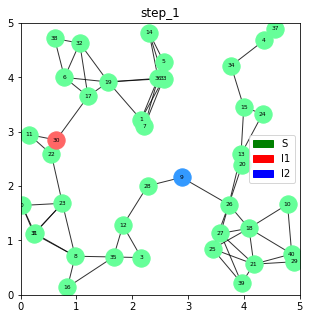

In [17]:
paramet = {
        'alpha': [0.5, 0.5], # infect rate 
        'mu': [0.5, 0.5], # sleep s 
        'gamma': [0.1, 0.1], # rec rate 
        'lambda': [0.7, 0.2], # sleep I1 
        'kappa': [0.7, 0.2] # sleep I2    % [I2_s -> I2_a, I2_a -> I2_s]
    }
np.random.seed(787)
random.seed(4)
# N = 5
r = 1
number_subgraphs = 0

while number_subgraphs != 1:
    a = EpidemicGraph(N,r,paramet,I1_a=1, I2_a=1, grid_size=[5,5], create=True) # net='Uniform Grid'
    number_subgraphs = len(list(nx.connected_component_subgraphs(a.G)))
    number_isolated_nodes = len(list(nx.isolates(a.G)))
    print(calc_R0(a.G, paramet), (number_subgraphs, number_isolated_nodes))

G = a.G
# G.node[0]['state'] = 'S_s'


plt, fig = plot(G, ns=300, fs=6,lim=5)
# plt.show()
fig.savefig('figures/_.png')

In [18]:
G.node[1]

msg_list = []
for node_id in range(N):
    neighbours = list(G[node_id])
    msg = {
        "id": node_id,
        "state": G.node[node_id]['state'],
        "neighbours": neighbours
    }
    msg_list.append(msg)
    print(msg)
    
mqttc.publish('init', json.dumps(msg_list))

{'id': 0, 'state': 'S_a', 'neighbours': [2, 23, 31]}
{'id': 1, 'state': 'S_a', 'neighbours': [7, 19, 33, 36]}
{'id': 2, 'state': 'S_a', 'neighbours': [0, 8, 23, 31]}
{'id': 3, 'state': 'S_a', 'neighbours': [12, 35]}
{'id': 4, 'state': 'S_a', 'neighbours': [34, 37]}
{'id': 5, 'state': 'S_a', 'neighbours': [14, 33, 36]}
{'id': 6, 'state': 'S_a', 'neighbours': [17, 19, 32, 38]}
{'id': 7, 'state': 'S_a', 'neighbours': [1, 33, 36]}
{'id': 8, 'state': 'S_a', 'neighbours': [2, 16, 23, 31, 35]}
{'id': 9, 'state': 'I2_a', 'neighbours': [26, 28]}
{'id': 10, 'state': 'S_a', 'neighbours': [18, 40]}
{'id': 11, 'state': 'S_a', 'neighbours': [22, 30]}
{'id': 12, 'state': 'S_a', 'neighbours': [3, 28, 35]}
{'id': 13, 'state': 'S_a', 'neighbours': [15, 20, 24, 26]}
{'id': 14, 'state': 'S_a', 'neighbours': [5, 33, 36]}
{'id': 15, 'state': 'S_a', 'neighbours': [13, 24, 34]}
{'id': 16, 'state': 'S_a', 'neighbours': [8, 35]}
{'id': 17, 'state': 'S_a', 'neighbours': [6, 19, 30, 32]}
{'id': 18, 'state': 'S_a'

In [8]:
# node_set = {str(x) for x in range(5)}
# mqttc.publish('finish', 0, qos=2)
node_set


{'4'}

In [ ]:
mqttc.loop_stop()

In [ ]:
mqttc.publish('next', 'dummy_msg', qos=2)

In [ ]:
mqttc.publish('stop', 'dummy_msg', qos=2)

In [ ]:
mqttc.publish('kill', 'process die', qos=2)

In [ ]:
mqttc.publish('paramet', json.dumps(paramet), qos=2)

In [19]:
mqttc.publish('start', 'dummy_msg', qos=2)

-t state | -p {"state": "S_a", "id": 27, "step": 0}
-t state | -p {"state": "S_a", "id": 27, "step": 0}
-t state | -p {"id": 29, "step": 0, "state": "S_a"}
-t state | -p {"id": 29, "step": 0, "state": "S_a"}
-t state | -p {"id": 40, "step": 0, "state": "S_a"}
-t state | -p {"id": 40, "step": 0, "state": "S_a"}
-t state | -p {"id": 32, "state": "S_a", "step": 0}
-t state | -p {"id": 32, "state": "S_a", "step": 0}
-t state | -p {"state": "S_a", "step": 0, "id": 13}
-t state | -p {"id": 23, "state": "S_a", "step": 0}
-t state | -p {"step": 0, "state": "S_a", "id": 6}
-t state | -p {"id": 28, "state": "S_a", "step": 0}
-t state | -p {"id": 34, "state": "S_a", "step": 0}
-t state | -p {"state": "S_a", "id": 24, "step": 0}
-t state | -p {"step": 0, "id": 38, "state": "S_a"}
-t state | -p {"step": 0, "id": 11, "state": "S_a"}
-t state | -p {"step": 0, "id": 4, "state": "S_a"}
-t finish | -p 37
-t finish | -p 30
-t state | -p {"state": "S_a", "step": 0, "id": 13}
-t state | -p {"id": 23, "stat

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dd/.virtualenvs/pi/lib/python3.6/site-packages/paho/mqtt/client.py", line 2913, in _thread_main
    self.loop_forever(retry_first_connection=True)
  File "/home/dd/.virtualenvs/pi/lib/python3.6/site-packages/paho/mqtt/client.py", line 1578, in loop_forever
    rc = self.loop(timeout, max_packets)
  File "/home/dd/.virtualenvs/pi/lib/python3.6/site-packages/paho/mqtt/client.py", line 1072, in loop
    rc = self.loop_read(max_packets)
  File "/home/dd/.virtualenvs/pi/lib/python3.6/site-packages/paho/mqtt/client.py", line 1374, in loop_read
    rc = self._packet_read()
  File "/home/dd/.virtualenvs/pi/lib/python3.6/site-packages/paho/mqtt/client.py", line 2071, in _packet_read
    rc = self._packet_handle()
  File "/home/d

-t state | -p {"id": 30, "step": 1, "state": "S_a"}
-t state | -p {"state": "S_s", "step": 1, "id": 25}
-t state | -p {"state": "S_s", "id": 39, "step": 1}
-t state | -p {"state": "S_s", "id": 35, "step": 1}
-t finish | -p 26


In [ ]:
mqttc.reinitialise()
mqttc.loop_start()

In [ ]:
a = ['python node_{0}/pi_main_2.py node_{0}'.format(i) for i in range(0, 5)]
str.join(' & ', a)

In [6]:
my_id_list = [0,1,2,3,4]
nextflag = {my_id: True for my_id in my_id_list}
nextflag[1] = False
all(nextflag.values())
nextflag

{0: True, 1: False, 2: True, 3: True, 4: True}